
HW 2 - DATA MINING

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from gensim.models import KeyedVectors
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.linear_model import LogisticRegression





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the data
TrainData_df = pd.read_csv('24_train_1.csv') #Loading Raw Train Data
TestData_df = pd.read_csv('news-test.csv') #Loading Raw Test Data

**PREPROCESSING**

In [4]:
# Preprocessing function
stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def preprocess_text(text):
    # Turn the document into lowercase
    text = text.lower()
    # Remove punctuations
    text = text.translate(remove_punctuation_map)
    # Tokenize the document
    tokens = nltk.word_tokenize(text)
    # Remove stop words and apply stemming
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stopwords.words('english')]
    # Join the filtered tokens into a single string
    return ' '.join(filtered_tokens)




In [5]:
# Apply preprocessing
TrainData_df['Text'] = TrainData_df['Text'].apply(preprocess_text)
TestData_df['Text'] = TestData_df['Text'].apply(preprocess_text)


# **1. A**

**Neural Networks with 2 hidden layers, 128 neurons, extracting features from count vectorizer and using 5-fold cross-validation to evaluate the performance.**


In [6]:
# Neural Network Model
def custom_cross_validate(X, y, model, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    training_accuracies = []
    validation_accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        # Training accuracy
        y_train_pred = model.predict(X_train)
        training_accuracy = accuracy_score(y_train, y_train_pred)
        training_accuracies.append(training_accuracy)

        # Validation accuracy
        y_test_pred = model.predict(X_test)
        validation_accuracy = accuracy_score(y_test, y_test_pred)
        validation_accuracies.append(validation_accuracy)

    return np.mean(training_accuracies), np.std(training_accuracies), np.mean(validation_accuracies), np.std(validation_accuracies)

mlp_model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=300)



### **1. B**

**COUNT VECTORIZER**

In [7]:
# Feature Generation
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(TrainData_df['Text'])


word embeddings using **TFIDF**

In [8]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(TrainData_df['Text'])

In [9]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(TrainData_df['Category'])



In [10]:

train_acc_mean_count, train_acc_std_count, val_acc_mean_count, val_acc_std_count = custom_cross_validate(X_count, y_encoded, mlp_model)

train_acc_mean_tfidf, train_acc_std_tfidf, val_acc_mean_tfidf, val_acc_std_tfidf = custom_cross_validate(X_tfidf, y_encoded, mlp_model)


# **BERT** -
commented as the model takes 20 min to run and gives only 95% accuracy

In [11]:
# pip install transformers

In [12]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import torch
# from tabulate import tabulate
# from transformers import BertTokenizer, BertModel

# model_name = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertModel.from_pretrained(model_name)

# def generate_bert_embeddings(text):
#     input_ids = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**input_ids)
#     embeddings = outputs.last_hidden_state.mean(dim=1)
#     return embeddings[0].numpy()

# # Create BERT embeddings for the dataset
# bert_embeddings = np.array([generate_bert_embeddings(text) for text in TrainData_df['Text']])


# #BERT EVALUATION
# train_acc_mean_bert, train_acc_std_bert, val_acc_mean_bert, val_acc_std_bert = custom_cross_validate(bert_embeddings, y_encoded, mlp_model)

## **GLOVE**

In [13]:
glove_model =  KeyedVectors.load_word2vec_format('glove.6B.100d.word2vec.txt') # Need to download this file and save it on your drive

In [14]:
def get_average_word_embedding_gensim(text, model):
    tokens = text.split()
    word_vectors = [model[word] if word in model.key_to_index else np.zeros(model.vector_size) for word in tokens]
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(model.vector_size)

glove_embeddings = np.array([get_average_word_embedding_gensim(text, glove_model) for text in TrainData_df['Text']])
train_acc_mean_glove, train_acc_std_glove, val_acc_mean_glove, val_acc_std_glove = custom_cross_validate(glove_embeddings, y_encoded, mlp_model)

## **1. C** - explained in description.pdf

## **1. D**
table to displa the training and validation accuracies for TFIDF, CountVectorizer and GloVe

In [15]:
# DFisplaying the accuracies in a table
# data = {
#     "Feature Method": ["CountVectorizer", "TFIDF", "BERT", "GloVe"],
#     "Training Accuracy Mean": [train_acc_mean_count, train_acc_mean_tfidf, train_acc_mean_bert, train_acc_mean_glove],
#     "Training Accuracy Std": [train_acc_std_count, train_acc_std_tfidf, train_acc_std_bert, train_acc_std_glove],
#     "Validation Accuracy Mean": [val_acc_mean_count, val_acc_mean_tfidf, val_acc_mean_bert, val_acc_mean_glove],
#     "Validation Accuracy Std": [val_acc_std_count, val_acc_std_tfidf, val_acc_std_bert, val_acc_std_glove]
# }

data = {
    "Feature Method": ["CountVectorizer", "TFIDF",  "GloVe"],
    "Training Accuracy Mean": [train_acc_mean_count, train_acc_mean_tfidf,  train_acc_mean_glove],
    "Training Accuracy Std": [train_acc_std_count, train_acc_std_tfidf,  train_acc_std_glove],
    "Validation Accuracy Mean": [val_acc_mean_count, val_acc_mean_tfidf,  val_acc_mean_glove],
    "Validation Accuracy Std": [val_acc_std_count, val_acc_std_tfidf,  val_acc_std_glove]
}

report_df = pd.DataFrame(data)
from tabulate import tabulate

table_string = tabulate(report_df, headers='keys', tablefmt='pipe', showindex=False)
print(table_string)

| Feature Method   |   Training Accuracy Mean |   Training Accuracy Std |   Validation Accuracy Mean |   Validation Accuracy Std |
|:-----------------|-------------------------:|------------------------:|---------------------------:|--------------------------:|
| CountVectorizer  |                        1 |                       0 |                      0.971 |                0.0111355  |
| TFIDF            |                        1 |                       0 |                      0.976 |                0.00583095 |
| GloVe            |                        1 |                       0 |                      0.953 |                0.0107703  |


## **1. E**
Dipalying the bar chart showing the accuracies for TFIDF, CountVectorizer and GloVe

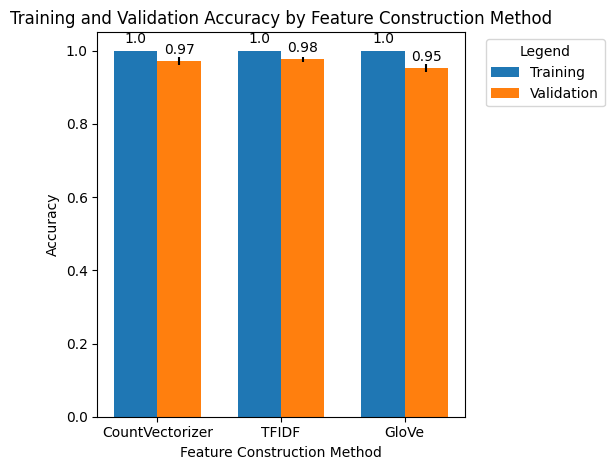

In [16]:
# Drawing a bar chart
features = ['CountVectorizer', 'TFIDF',
          # ,  'BERT',
            'GloVe']
x = np.arange(len(features))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data['Training Accuracy Mean'], width, yerr=data['Training Accuracy Std'], label='Training')
rects2 = ax.bar(x + width/2, data['Validation Accuracy Mean'], width, yerr=data['Validation Accuracy Std'], label='Validation')


ax.set_xlabel('Feature Construction Method')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Feature Construction Method')
ax.set_xticks(x)
ax.set_xticklabels(features)
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title="Legend")

def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# **2. A**
explained in description.pdf

# **2. B**

The TFIDF gave the best performance from the previously used feature engineering method. The accuracy was 97.7%

In [17]:
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
results_df = pd.DataFrame(columns=['Learning Rate', 'Training Accuracy Mean', 'Training Accuracy Std', 'Validation Accuracy Mean', 'Validation Accuracy Std'])

In [18]:
for lr in learning_rates:

    mlp_model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=300, learning_rate_init=lr)


    train_acc_mean, train_acc_std, val_acc_mean, val_acc_std = custom_cross_validate(X_tfidf, y_encoded, mlp_model)


    results_df = results_df.append({
        'Learning Rate': lr,
        'Training Accuracy Mean': train_acc_mean,
        'Training Accuracy Std': train_acc_std,
        'Validation Accuracy Mean': val_acc_mean,
        'Validation Accuracy Std': val_acc_std
    }, ignore_index=True)

<ipython-input-18-9307db61ae34>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-18-9307db61ae34>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-18-9307db61ae34>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-18-9307db61ae34>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-18-9307db61ae34>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = resul

# **2. B. 1**

In [19]:
print(tabulate(results_df, headers='keys', tablefmt='pipe', showindex=False))

|   Learning Rate |   Training Accuracy Mean |   Training Accuracy Std |   Validation Accuracy Mean |   Validation Accuracy Std |
|----------------:|-------------------------:|------------------------:|---------------------------:|--------------------------:|
|          0.0001 |                    1     |                   0     |                      0.972 |                0.00979796 |
|          0.0003 |                    1     |                   0     |                      0.976 |                0.00583095 |
|          0.001  |                    1     |                   0     |                      0.973 |                0.00748331 |
|          0.003  |                    1     |                   0     |                      0.975 |                0.00547723 |
|          0.01   |                    1     |                   0     |                      0.965 |                0.0130384  |
|          0.03   |                    1     |                   0     |                  

# **2. B. 2**

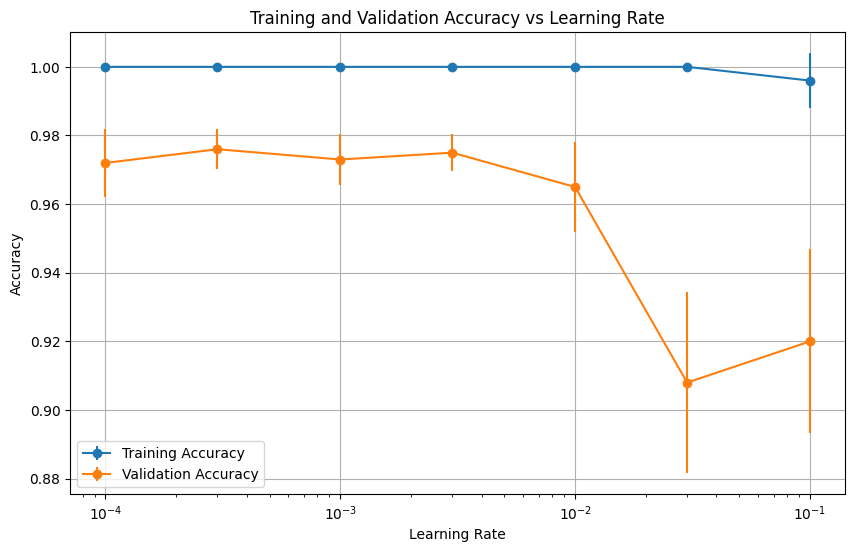

In [20]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df['Learning Rate'], results_df['Training Accuracy Mean'], yerr=results_df['Training Accuracy Std'], label='Training Accuracy', fmt='-o')
plt.errorbar(results_df['Learning Rate'], results_df['Validation Accuracy Mean'], yerr=results_df['Validation Accuracy Std'], label='Validation Accuracy', fmt='-o')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

**PRINTING THE BEST PERFORMANCE**

In [21]:

best_accuracy_row = results_df.loc[results_df["Validation Accuracy Mean"].idxmax()]
best_learning_rate = best_accuracy_row["Learning Rate"]
best_validation_accuracy = best_accuracy_row["Validation Accuracy Mean"]

print(f"The highest validation accuracy achieved is {best_validation_accuracy}, with a learning rate of {best_learning_rate}.")


The highest validation accuracy achieved is 0.976, with a learning rate of 0.0003.


# **2. C**
 5-fold cross-validation to evaluate the performance with respect to
 SGD, Adam, RMSprop optimizers

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import legacy as keras_legacy_optimizers

# Transforming the documents using TF-IDF
tfidf_transformer = TfidfVectorizer(max_features=10000)
tfidf_features = tfidf_transformer.fit_transform(TrainData_df['Text']).toarray()
print("Dimensions of the TF-IDF feature matrix:", tfidf_features.shape)



Dimensions of the TF-IDF feature matrix: (1000, 10000)


In [23]:
# Define optimizers to test
optimizer_options = [keras_legacy_optimizers.SGD(), keras_legacy_optimizers.Adam(), keras_legacy_optimizers.RMSprop()]
optimizer_labels = ['SGD', 'Adam', 'RMSprop']

# Initialize dictionary to store the performance results
eval_metrics = {label: {'train_acc': [], 'test_acc': []} for label in optimizer_labels}
class_labels = y_encoded

# Configuring Stratified K-Fold for validation
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training and evaluation loop
for optimizer, label in zip(optimizer_options, optimizer_labels):
    for train_indices, test_indices in cross_val.split(tfidf_features, class_labels):
        X_train, X_test = tfidf_features[train_indices], tfidf_features[test_indices]
        y_train, y_test = class_labels[train_indices], class_labels[test_indices]

        model = Sequential([
            InputLayer(input_shape=(X_train.shape[1],)),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(len(np.unique(class_labels)), activation='softmax')
        ])

        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        _, accuracy_train = model.evaluate(X_train, y_train, verbose=0)
        _, accuracy_test = model.evaluate(X_test, y_test, verbose=0)

        eval_metrics[label]['train_acc'].append(accuracy_train)
        eval_metrics[label]['test_acc'].append(accuracy_test)






In [24]:
# results
summary_labels = []
train_acc_avg = []
train_acc_std = []
test_acc_avg = []
test_acc_std = []

for label in optimizer_labels:
    train_avg = np.mean(eval_metrics[label]['train_acc'])
    train_std = np.std(eval_metrics[label]['train_acc'])
    test_avg = np.mean(eval_metrics[label]['test_acc'])
    test_std = np.std(eval_metrics[label]['test_acc'])

    summary_labels.append(label)
    train_acc_avg.append(train_avg)
    train_acc_std.append(train_std)
    test_acc_avg.append(test_avg)
    test_acc_std.append(test_std)

# Assembling the summary into a DataFrame for display
summary_df = pd.DataFrame({
    'Optimizer': summary_labels,
    'Train Accuracy Mean': train_acc_avg,
    'Train Accuracy STD': train_acc_std,
    'Validation Accuracy Mean': test_acc_avg,
    'Validation Accuracy STD': test_acc_std
})

display(summary_df)

,Optimizer,Train Accuracy Mean,Train Accuracy STD,Validation Accuracy Mean,Validation Accuracy STD
0,SGD,0.254,0.025303,0.250,0.021679
1,Adam,1.000,0.000000,0.968,0.019391
2,RMSprop,1.000,0.000000,0.970,0.015166


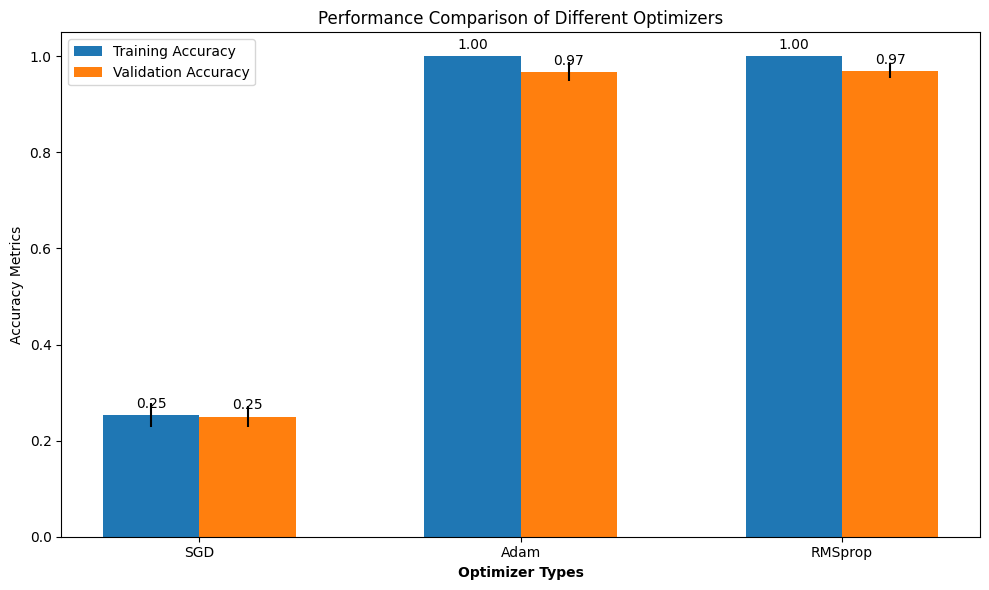

In [25]:
# Visualization of results
bar_width = 0.3
indices = np.arange(len(summary_df))
offsets = [x + bar_width for x in indices]

plt.figure(figsize=(10, 6))
blue = plt.bar(indices, summary_df['Train Accuracy Mean'], width=bar_width, label='Training Accuracy', yerr=summary_df['Train Accuracy STD'])
orange = plt.bar(offsets, summary_df['Validation Accuracy Mean'], width=bar_width, label='Validation Accuracy', yerr=summary_df['Validation Accuracy STD'])

plt.xlabel('Optimizer Types', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(summary_df))], summary_df['Optimizer'])
plt.ylabel('Accuracy Metrics')
plt.title('Performance Comparison of Different Optimizers')

plt.legend()
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(blue)
autolabel(orange)

fig.tight_layout()

plt.tight_layout()
plt.show()

In [26]:

print(tabulate(results_df, headers='keys', tablefmt='pipe', showindex=False))

|   Learning Rate |   Training Accuracy Mean |   Training Accuracy Std |   Validation Accuracy Mean |   Validation Accuracy Std |
|----------------:|-------------------------:|------------------------:|---------------------------:|--------------------------:|
|          0.0001 |                    1     |                   0     |                      0.972 |                0.00979796 |
|          0.0003 |                    1     |                   0     |                      0.976 |                0.00583095 |
|          0.001  |                    1     |                   0     |                      0.973 |                0.00748331 |
|          0.003  |                    1     |                   0     |                      0.975 |                0.00547723 |
|          0.01   |                    1     |                   0     |                      0.965 |                0.0130384  |
|          0.03   |                    1     |                   0     |                  

3. D

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
import tensorflow.keras.optimizers as keras_optimizers

tfidf_vectorizer = TfidfVectorizer()

df_train_custom = TrainData_df
df_test_custom = TestData_df
X_tf_custom = tfidf_vectorizer.fit_transform(df_train_custom['Text']).toarray()
X_test_tf_custom = tfidf_vectorizer.transform(df_test_custom['Text']).toarray()


label_encoder_custom = LabelEncoder()
y_enc_custom = label_encoder_custom.fit_transform(df_train_custom['Category'])


X_train_custom, X_val_custom, y_train_custom, y_val_custom = train_test_split(X_tf_custom, y_enc_custom, test_size=0.2, random_state=42)


model_custom = Sequential([
    layers.Input(shape=(X_train_custom.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])


optimizer_custom = keras_optimizers.Adam(learning_rate=0.03)

model_custom.compile(optimizer=optimizer_custom,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_custom = model_custom.fit(X_train_custom, y_train_custom, epochs=10, batch_size=32, validation_data=(X_val_custom, y_val_custom))

train_acc_custom = history_custom.history['accuracy'][-1]
val_acc_custom = history_custom.history['val_accuracy'][-1]

predictions_custom = model_custom.predict(X_test_tf_custom)
predicted_classes_custom = predictions_custom.argmax(axis=-1)
predicted_labels_custom = label_encoder_custom.inverse_transform(predicted_classes_custom)


Epoch 1/10
25/25 [==============================] - 2s 59ms/step - loss: 0.4735 - accuracy: 0.8612 - val_loss: 0.2680 - val_accuracy: 0.9300
Epoch 2/10
25/25 [==============================] - 1s 48ms/step - loss: 0.0217 - accuracy: 0.9937 - val_loss: 0.0350 - val_accuracy: 0.9900
Epoch 3/10
25/25 [==============================] - 1s 42ms/step - loss: 4.2592e-04 - accuracy: 1.0000 - val_loss: 0.0722 - val_accuracy: 0.9700
Epoch 4/10
25/25 [==============================] - 1s 35ms/step - loss: 1.3868e-05 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.9700
Epoch 5/10
25/25 [==============================] - 1s 34ms/step - loss: 3.3690e-06 - accuracy: 1.0000 - val_loss: 0.0774 - val_accuracy: 0.9750
Epoch 6/10
25/25 [==============================] - 1s 34ms/step - loss: 1.6665e-06 - accuracy: 1.0000 - val_loss: 0.0747 - val_accuracy: 0.9750
Epoch 7/10
25/25 [==============================] - 1s 34ms/step - loss: 8.3964e-07 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 

In [32]:
print(train_acc_custom, val_acc_custom)

1.0 0.9750000238418579


In [33]:
import csv

folder_path = '/content/gdrive/MyDrive/DM - HW2/' # change path
file_name = 'labels.csv'
full_file_path = folder_path + file_name

res = pd.DataFrame()
res['ArticleId'] = df_test_custom['ArticleId']
res['Category'] = predicted_labels_custom
res.to_csv(file_name, index = False, header = False, sep = ',')


print(f"File saved successfully at: {full_file_path}")


File saved successfully at: /content/gdrive/MyDrive/DM - HW2/labels.csv
